## Tutorial: VIS Image Pipeline

PlantCV is composed of modular functions that can be arranged (or rearranged) and adjusted quickly and easily.
Pipelines do not need to be linear (and often are not). Please see pipeline example below for more details.
Every function has a optional debug mode that prints out the resulting image. The debug has two modes, either 'plot' or print' if set to
'print' then the function prints the image out, if using a jupyter notebook, you would set debug to plot to have
the images plot images to the screen. Debug mode allows users to visualize and optimize each step on individual test images and small test sets before pipelines are deployed over whole data-sets.

**Workflow**

1.  Optimize pipeline on individual image in debug mode.
2.  Run pipeline on small test set (ideally that spans time and/or treatments).
3.  Re-optimize pipelines on 'problem images' after manual inspection of test set.
4.  Deploy optimized pipeline over test set using parallelization script.

**Running A Pipeline**

To run a VIS pipeline over a single VIS image there are two required inputs:

1.  **Image:** Images can be processed regardless of what type of VIS camera was used (High-throughput platform, digital camera, cell phone camera).
Image processing will work with adjustments if images are well lit and free of background that is similar in color to plant material.  
2.  **Output directory:** If debug mode is on output images from each step are produced, otherwise ~4 final output images are produced.

Optional inputs:  

*  **Result File** file to print results to
*  **Write Image Flag** flag to write out images, otherwise no result images are printed (to save time).
*  **Debug Flag:** Prints an image at each step
*  **Region of Interest:** The user can input their own binary region of interest or image mask (make sure it is the same size as your image or you will have problems).

Sample command to run a pipeline on a single image:  

*  Always test pipelines (preferably with -D flag for debug mode) before running over a full image set

```
./pipelinename.py -i testimg.png -o ./output-images -r results.txt -w -D 'print'
```

### Walk Through A Sample Pipeline

#### Pipelines start by importing necessary packages, and by defining user inputs.

In [7]:
# Plot images in line 
%matplotlib inline
import matplotlib
# Set the desired figure size to get printed out 
matplotlib.rcParams["figure.figsize"] = (8.0, 8.0)
# Import PlantCV 
from plantcv import plantcv as pcv

We can create an `options` class to mimic parsed command-line arguments from the module argparse

In [3]:
class options:
    def __init__(self):
        self.image = "img/tutorial_images/vis/original_image.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "vis_tutorial_results.txt"

#### Start of the Main/Customizable portion of the pipeline.

The image input by the user is read in. The device variable is just a counter so that each debug image is labeled in numerical order.

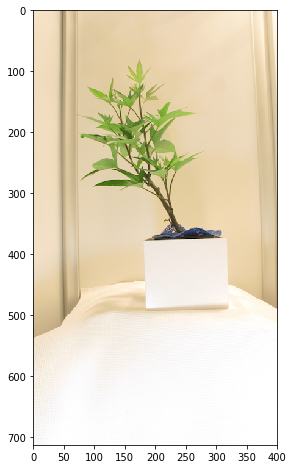

In [8]:
# Get options
args = options()

# Read image
img, path, filename = pcv.readimage(args.image, args.debug)

In [ ]:
# Convert RGB to HSV and extract the saturation channel
s = pcv.rgb2gray_hsv(img, 's')

In [ ]:
# Threshold the saturation image 
s_thresh = pcv.binary_threshold(s, 30, 255, 'light')

In [ ]:
# Use median blur on the thresholded image
s_mblur = pcv.median_blur(s_thresh, 5)
s_cnt = pcv.median_blur(s_thresh, 5)